In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.colors as cl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import histlib.box as box
import histlib.aviso as aviso
import histlib.cstes as cstes
import histlib.diagnosis as diag
from histlib.cstes import labels, zarr_dir, matchup_dir

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=5, processes=5, walltime='02:00:00')
    w = cluster.scale(jobs=4)
    #w = cluster.scale(jobs=3)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.72:8787/status,
Dashboard: http://10.148.1.72:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.72:42590,Workers: 0
Dashboard: http://10.148.1.72:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Create csv files

In [53]:
comb = {'acc':'drifter_acc_x_25', 'cor':'drifter_coriolis_x_25', 'ggx':'aviso_drifter_ggx_adt', 'wd':'es_cstrio_z15_drifter_wd_x'}

def build_matchup_dataframe(comb, drifter_type = None, drogue_status=None):
    from histlib.cstes import labels
    # gps/argos
    if drifter_type : 
        labels = [l for l in labels if drifter_type in l]
    DF =[]
    for l in labels :
        paths = [f'/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/matchup/matchup_{l}.zarr'] + glob(os.path.join(f'/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/cutoff_matchup/cutoff_matchup_{l}*.zarr'))
        df = xr.merge([xr.open_dataset(path) for path in paths])[[comb[key] for key in comb]+['drogue_status']].to_dataframe()
        if drogue_status :
            df = df.where(df.drogue_status==drogue_status).dropna()
        DF.append(df)
        print(l)
    
    df = pd.concat(DF)
    df = df.rename(columns = {comb[key]:key for key in comb}).reset_index()[['obs','acc','cor','drogue_status','ggx','wd','alti___distance','alti___time_difference','lat','lon','time']]

    tms = [tm for tm in comb]
    
    # residual
    df['s'] = df[[tm for tm in comb]].sum(axis=1)
    
    # correlations
    from itertools import combinations
    correlation = list(combinations(tms, 2))
    for c in correlation :
        df[f'{c[0]}_{c[1]}'] = df[c[0]]*df[c[1]]

    for tm in tms :
        #Errors parts
        df['E_'+tm] = df.s*df[tm]
        # Observed balanced parts
        df['B_'+tm] = -df[[f'{c[0]}_{c[1]}' for c in correlation if tm in f'{c[0]}_{c[1]}']].sum(axis=1)

    #Contributions
    for c in correlation :
        df['X_'+f'{c[0]}_{c[1]}'] = -2*df[f'{c[0]}_{c[1]}']

    for tm in tms + ['s'] :
        df[tm.upper()] = df[tm]**2
    
    df['sigma'] = df[[tm.upper() for tm in tms]].sum(axis=1)
    
    return df

                
    

In [54]:
df = build_matchup_dataframe(comb, drifter_type = None, drogue_status=True)

gps_Jason-3_2020
argos_Jason-3_2020
gps_SARAL_2020
argos_SARAL_2020
gps_Cryosat-2_2020
argos_Cryosat-2_2020
gps_Sentinel-3_A_2020
argos_Sentinel-3_A_2020
gps_Sentinel-3_B_2020
argos_Sentinel-3_B_2020
gps_Jason-3_2019
argos_Jason-3_2019
gps_SARAL_2019
argos_SARAL_2019
gps_Cryosat-2_2019
argos_Cryosat-2_2019
gps_Sentinel-3_A_2019
argos_Sentinel-3_A_2019
gps_Sentinel-3_B_2019
argos_Sentinel-3_B_2019
gps_Jason-3_2018
argos_Jason-3_2018
gps_SARAL_2018
argos_SARAL_2018
gps_Cryosat-2_2018
argos_Cryosat-2_2018
gps_Sentinel-3_A_2018
argos_Sentinel-3_A_2018
gps_Sentinel-3_B_2018
argos_Sentinel-3_B_2018
gps_Jason-3_2017
argos_Jason-3_2017
gps_Jason-2_2017
argos_Jason-2_2017
gps_SARAL_2017
argos_SARAL_2017
gps_Cryosat-2_2017
argos_Cryosat-2_2017
gps_Sentinel-3_A_2017
argos_Sentinel-3_A_2017
gps_Jason-3_2016
argos_Jason-3_2016
gps_Jason-2_2016
argos_Jason-2_2016
gps_SARAL_2016
argos_SARAL_2016
gps_Cryosat-2_2016
argos_Cryosat-2_2016
gps_Sentinel-3_A_2016
argos_Sentinel-3_A_2016
gps_Jason-2_2015
arg

In [44]:
dl = 5000
df["distbin"] = (df.alti___distance // dl) * dl

In [61]:
tms = [tm for tm in comb]
df['sigma'] = df[[tm.upper() for tm in tms]].sum(axis=1)

In [62]:
df_  = df.where(df.alti___distance<25000).where(df.alti___time_difference<30*60)

In [51]:
ds = df_.to_xarray().mean()

In [64]:
from histlib.cstes import labels,c0

In [96]:
def synthetic_figure(df, ax, xlim=None) :
    plt.rcParams["axes.edgecolor"] = "w"
    a=1.5
    bbox = dict(facecolor='w', alpha=0.8, edgecolor='w')
    
    ts = df['sigma']
    print(ts)
    #gap between bars for readability
    if xlim : b=xlim/400
    else : b=ts/400

    #b = 1e-10
    
    ## INDIVIDUAL MS ##
    ax.barh(2*a, df['ACC'], color= c0['acc'], label = 'Inertial acceleration')
    ax.barh(2*a, df['COR'], left =df['ACC']+b , color= c0['coriolis'], label = 'Coriolis acceleration')
    ax.barh(2*a, df['GGX'], left =df['ACC']+df['COR']+2*b , color= c0['ggrad'], label = 'Pressure gradient term')
    ax.barh(2*a, df['WD'], left =df['ACC']+df['COR']+df['GGX']+3*b, color= c0['wind'], label = 'Wind term')
    

    ax.text(ts/2, 2*a+0.5, r'Individual MS $A_i$', ha='center') 
    #percentage + MS
    key = ['ACC', 'COR', 'GGX', 'WD']
    for i in range(len(key)) :
        ax.text(sum([df[v] for v in key[:i]])+df[key[i]]/2+i*b, 2*a, f'{int(np.rint((df[key[i]]/ts)*100))} %', ha='center',bbox=bbox )
        ax.text(sum([df[v] for v in key[:i]])+df[key[i]]/2+i*b, 2*a-0.55, f'{np.format_float_scientific(df[key[i]],precision = 1)}', ha='center')
    
    #accolade
    c = 1e-12
    id1 =0
    id2 = ts + 3*b
    bx = [id1, id1, id2, id2]
    by = [3.70, 3.75, 3.75, 3.70]
    ax.plot(bx, by, 'k-', lw=2)
    ax.text(ts, 3.8, r'$\Sigma$', fontsize=15, ha='center')
    
    ## CAPTURED PHYSICAL + ERRORS PARTS ##
    ax.barh(1*a, df['B_acc'], color= c0['acc'])
    ax.barh(1*a, df['E_acc'], left = df['B_acc'], color= 'lightgrey', label='Errors')
    ax.barh(1*a, df['B_cor'], left =df['B_acc']+df['E_acc']+b, color= c0['coriolis'])
    ax.barh(1*a, df['E_cor'], left =df['B_acc']+df['E_acc']+ df['B_cor'], color= 'lightgrey')
    ax.barh(1*a, df['B_ggx'], left =df['B_acc']+df['E_acc']+ df['B_cor']+ df['E_cor']+b, color= c0['ggrad'])
    if df['E_ggx']>0 : 
        ax.barh(1*a, df['E_ggx'], left =df['B_acc']+df['E_acc']+ df['B_cor']+ df['E_cor']+df['B_ggx'], color= 'lightgrey')
        ax.barh(1*a, df['B_wd'], left =df['B_acc']+df['E_acc']+ df['B_cor']+ df['E_cor']+df['B_ggx']+df['E_ggx']+b, color= c0['wind'])
        ax.barh(1*a, df['E_wd'], left =df['B_acc']+df['E_acc']+ df['B_cor']+ df['E_cor']+df['B_ggx']+df['E_ggx']+df['B_wd'], color= 'lightgrey')
    else : 
        print('ok')
        ax.barh(1*a, df['B_wd'], left =df['B_acc']+df['E_acc']+ df['B_cor']+ df['E_cor']+df['B_ggx']+2*b, color= c0['wind'])
        ax.barh(1*a, df['E_wd'], left =df['B_acc']+df['E_acc']+ df['B_cor']+ df['E_cor']+df['B_ggx']+df['B_wd']+2*b, color= 'lightgrey')
    
    ax.text(ts/2, 1*a+0.5, r'Balanced physical and errors parts MS $B_i$ and $E_i$', ha='center') 
            
    #percentage + MS
    key = ['B_acc','E_acc', 'B_cor','E_cor', 'B_ggx','E_ggx', 'B_wd', 'E_wd']
    for i in range(len(key)) :
        d=0#vertical +
        dx=0#horizontal + on MS
        dxx=0#horizontal + on percentage
        if i==len(key)-1 : 
            d=-0.1*a 
            dx = 3e-11
            dxx = 1.5e-11
        if i==len(key)-2 : d=0.1*a 
        if aviso and i==len(key)-3 : d=-0.1*a
        ax.text(sum([df[v] for v in key[:i]])+ds[key[i]]/2+i*b/2+dxx, a+d, f'{int(np.rint((ds[key[i]]/ts)*100))} %', ha='center', bbox=bbox)
        d=0        
        if i%2 ==1 : d=-0.1*a
        ax.text(sum([df[v] for v in key[:i]])+ds[key[i]]/2+i*b/2+dx, a+d -0.55, f'{np.format_float_scientific(ds[key[i]],precision = 1)}', ha='center')
        
    ## PAIRS + RESIDUAL ##
    plt.rcParams['hatch.linewidth'] = 10
    plt.rcParams['hatch.color'] = c0['ggrad']
    ax.barh(0, df['X_cor_ggx'], color=c0['coriolis'], hatch='/')
    plt.rcParams['hatch.color'] = c0['coriolis']
    ax.barh(0, df['X_acc_cor'], color=c0['acc'], hatch='/', left = df['X_cor_ggx']+b)
    plt.rcParams['hatch.color'] = c0['acc']
    ax.barh(0, df['X_acc_ggx'], color=c0['ggrad'], hatch='/', left = df['X_cor_ggx']+df['X_acc_cor']+2*b)
    plt.rcParams['hatch.color'] = c0['wind']
    ax.barh(0, df['X_cor_wd'], color=c0['coriolis'], hatch='/', left = df['X_cor_ggx']+df['X_acc_cor']+df['X_acc_ggx']+3*b)
    ax.barh(0, df['S'], color='lightgrey', left = df['X_cor_ggx']+df['X_acc_cor']+df['X_acc_ggx']+df['X_cor_wd']+4*b)

    tts = df['X_cor_ggx']+df['X_acc_cor']+df['X_acc_ggx']+df['X_cor_wd']+4*b+ds['S']
    print(tts)
    sum_pairs = df['X_cor_ggx']+df['X_acc_cor']+df['X_acc_ggx']+df['X_cor_wd']+3*b
    ax.text(sum_pairs/2, 0.6, r"Pairs' contributions $X_{ij}$", ha='center')
    #accolade
    c = 1e-12
    id1 = 0
    id2 = sum_pairs
    bx = [id1, id1, id2, id2]
    by = [0.45, 0.5, 0.5, 0.45]
    ax.plot(bx, by, 'k-', lw=2)
    ax.text(sum_pairs + df['S']/2, 0.5, r'$S$', ha='center')

    #percentage + MS
    from itertools import combinations
    correlation = list(combinations(['acc', 'cor', 'ggx', 'wd'], 2))
    key = ['X_cor_ggx', 'X_acc_cor','X_acc_ggx','X_cor_wd']

    for i in range(len(key)) :
        ax.text(sum([df[v] for v in key[:i]])+df[key[i]]/2+i*b, 0, f'{int(np.rint((df[key[i]]/ts)*100))} %', ha='center', bbox=bbox)
        d=0
        if aviso and key[i]== 'X_acc_ggx' : d = -0.1*a
        ax.text(sum([df[v] for v in key[:i]])+df[key[i]]/2+i*b, 0-0.55+d, f'{np.format_float_scientific(df[key[i]],precision = 1)}', ha='center')
    
    ax.text(sum([df[v] for v in key])+df['S']/2+i*b, 0, f'{int(np.rint((df["S"]/ts)*100))} %', ha='center', bbox=bbox)
    ax.text(sum([df[v] for v in key])+df['S']/2+i*b, 0-0.55, f'{np.format_float_scientific(df["S"],precision = 1)}', ha='center')

    # FIGURE SET
    ax.set_yticks([])
    if not xlim : xlim=tts
    ax.set_xlim(-1e-11, xlim+1e-11)
    ax.set_ylim(-1, 4.1)
    ax.get_yaxis().set_visible(False)
    ax.annotate('',xy=(xlim,-1),xytext=(0,-1),arrowprops={'arrowstyle':'->', 'facecolor':'k'})
    ax.set_xlabel(r'$[m^2.s^{-4}]$')
    

6.765283188426474e-10
ok
<xarray.DataArray 'S' ()>
array(6.97018099e-10)


Text(0.5, 0.98, 'AVISO-drifter')

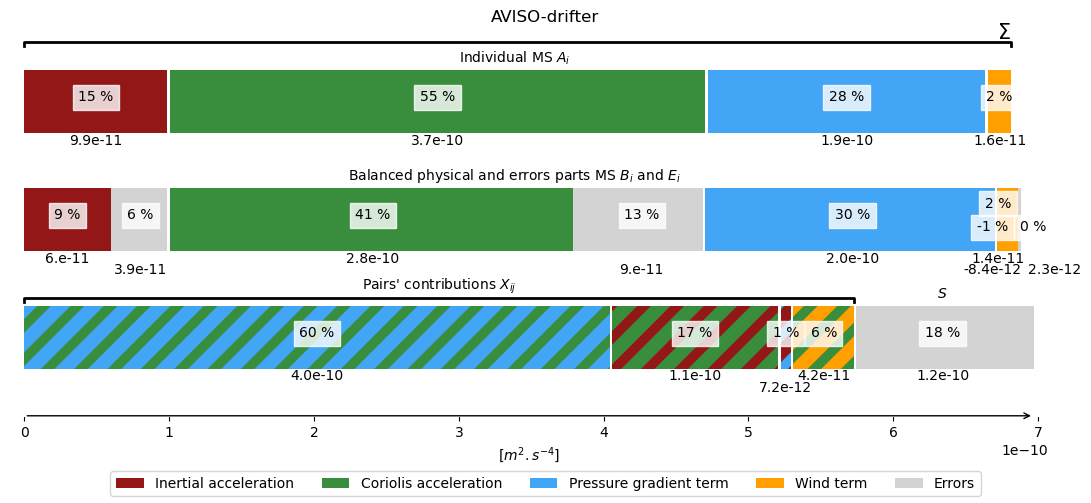

In [97]:
plt.rcParams["axes.edgecolor"] = "w"
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(11,5), frameon=False, )

synthetic_figure(df_.mean(), ax) 
fig.legend(ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.04,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.suptitle('AVISO-drifter')
#fig.savefig('images/synth_alg.png',bbox_inches='tight',   dpi=300)

In [91]:
df_.mean()

obs                       5.529455e+04
acc                       3.899765e-08
cor                      -3.446243e-08
drogue_status             1.000000e+00
ggx                       2.556463e-08
wd                       -1.208282e-08
alti___distance           1.276194e+04
alti___time_difference    8.708379e+02
lat                       3.804474e+00
lon                      -1.127321e+01
s                         1.801704e-08
acc_cor                  -5.732177e-11
acc_ggx                  -3.585636e-12
acc_wd                    1.242347e-12
cor_ggx                  -2.020575e-10
cor_wd                   -2.092675e-11
ggx_wd                    5.619901e-12
E_acc                     3.897514e-11
B_acc                     5.966506e-11
E_cor                     8.959488e-11
B_cor                     2.803060e-10
E_ggx                    -8.371063e-12
B_ggx                     2.000232e-10
E_wd                      2.270640e-12
B_wd                      1.406450e-11
X_acc_cor                

<Axes: >

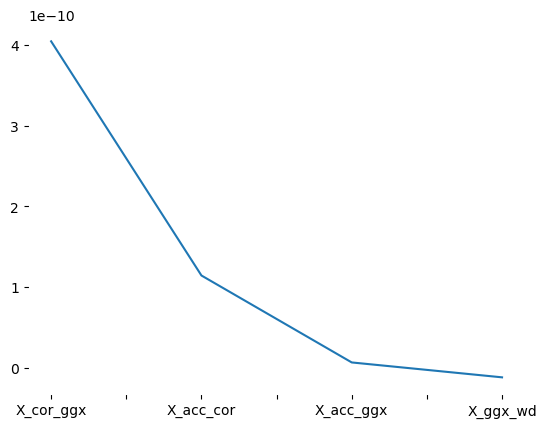

In [82]:
df_.mean()[['X_cor_ggx', 'X_acc_cor','X_acc_ggx','X_ggx_wd']].plot()

In [15]:
cluster.close()